# Customer Value Prediction and Segmentation
**A polished, end-to-end analysis**

This notebook presents the motivation, data sources, analysis steps, key findings, and future directions for predicting customer average order value.

## 🧭 Motivation
- Understand drivers of customer spending in e-commerce.
- Enable personalized marketing and resource allocation.
- Demonstrate how macroeconomic context influences customer behavior.

## 📥 Data Sources
1. **E-commerce transactions** (`datasets/data.csv`):
   - UK Online Retail dataset from Kaggle (Dec 2010–Dec 2011).
   - Fields: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country.

2. **World Development Indicators** (`datasets/wdi-csv-zip-57-mb-/WDIData.csv`):
   - World Bank macroeconomic indicators from Kaggle.
   - Over 1,600 indicators; we use population, internet usage, urbanization, and GDP per capita.

## 🧹 Data Preparation & Cleaning
### E-commerce Data
- Loaded with `ISO-8859-1` encoding.
- Dropped rows missing `CustomerID` or with non-positive `Quantity`.
- Computed `TotalPrice = UnitPrice * Quantity`.
- Extracted `Year` from `InvoiceDate`.
- Calculated `AvgOrderValue` per customer.

### WDI Data
- Selected only years overlapping with e-commerce data.
- Filtered to four indicators: population, internet usage %, urban %, GDP per capita.
- Melted from wide to long, then pivoted to wide form with one row per (Country, Year).

## 🔍 Data Analysis & Feature Engineering
Compute RFM features and enrich with macro indicators.

In [1]:
import pandas as pd, numpy as np

# Load and clean e-commerce
ecom_df = pd.read_csv('datasets/data.csv', encoding='ISO-8859-1', parse_dates=['InvoiceDate'])
ecom_df = ecom_df.dropna(subset=['CustomerID']).loc[lambda df: df.Quantity > 0]
ecom_df['TotalPrice'] = ecom_df.UnitPrice * ecom_df.Quantity
ecom_df['Year'] = ecom_df.InvoiceDate.dt.year

# Avg order value
avg_order = ecom_df.groupby('CustomerID').TotalPrice.mean().rename('AvgOrderValue').reset_index()

# RFM features
ref_date = ecom_df.InvoiceDate.max() + pd.Timedelta(days=1)
rfm = ecom_df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (ref_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()
rfm['LogMonetary'] = np.log1p(rfm.Monetary)



In [2]:
# WDI enrichment (fast subset)
years = ecom_df.Year.unique().astype(str).tolist()
usecols = ['Country Name','Country Code','Indicator Name','Indicator Code'] + years
wdi_df = pd.read_csv('datasets/wdi-csv-zip-57-mb-/WDIData.csv', usecols=usecols)
indicators = {'SP.POP.TOTL','IT.NET.USER.ZS','SP.URB.TOTL.IN.ZS','NY.GDP.PCAP.CD'}
wdi_df = wdi_df[wdi_df['Indicator Code'].isin(indicators)]
wdi_long = wdi_df.melt(id_vars=usecols[:4], value_vars=years, var_name='Year', value_name='Value')
wdi_long.Year = wdi_long.Year.astype(int)
wdi_wide = wdi_long.pivot_table(index=['Country Name','Year'], columns='Indicator Code', values='Value').reset_index()
wdi_wide.columns = ['Country','Year','Population','InternetUsersPct','UrbanPct','GDP_per_capita']
wdi_wide['LogGDPpc'] = np.log1p(wdi_wide.GDP_per_capita)

# Merge features
cust_meta = ecom_df[['CustomerID','Country','Year']].drop_duplicates()
feature_df = rfm.merge(cust_meta, on='CustomerID').merge(wdi_wide, on=['Country','Year'], how='left')
feature_df = feature_df.merge(avg_order, on='CustomerID')
feature_df.head()

,CustomerID,Recency,Frequency,Monetary,LogMonetary,Country,Year,Population,InternetUsersPct,UrbanPct,GDP_per_capita,LogGDPpc,AvgOrderValue
0,12346.0,326,1,77183.60,11.253955,United Kingdom,2011,85.379999,41652.557085,63258918.0,81.570,4.413646,77183.600000
1,12347.0,2,7,4310.00,8.368925,Iceland,2010,93.390000,43024.923838,318041.0,93.574,4.549383,23.681319
2,12347.0,2,7,4310.00,8.368925,Iceland,2011,94.819687,47516.875740,319014.0,93.587,4.549520,23.681319
3,12348.0,75,4,1797.24,7.494564,Finland,2010,86.890000,46202.415163,5363352.0,83.770,4.439942,57.975484
4,12348.0,75,4,1797.24,7.494564,Finland,2011,88.709995,50790.724145,5388272.0,84.313,4.446327,57.975484


## 📊 Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

### 1. Distribution of Average Order Value (EDA)
Understanding the distribution of our target variable (Average Order Value) helps identify spending patterns and opportunities for personalized marketing strategies.

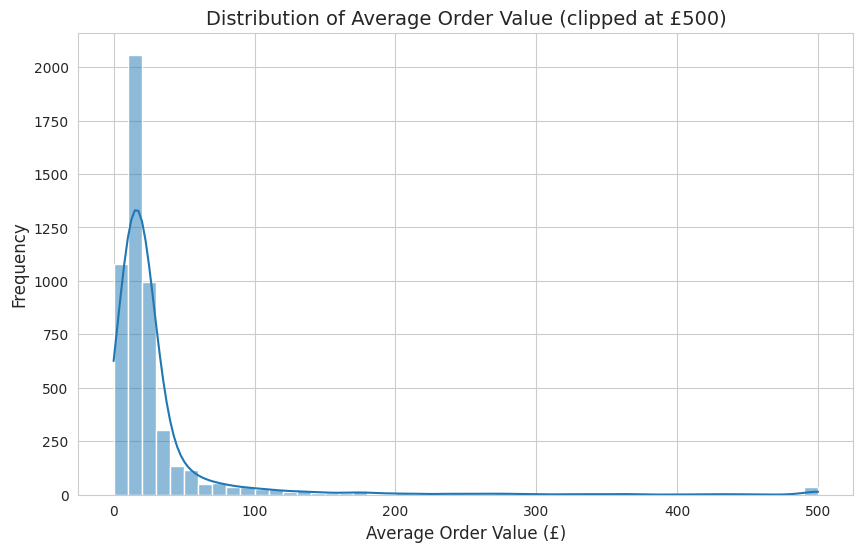

AvgOrderValue Statistics:
count     5113.000000
mean        63.395404
std       1352.451983
min          0.000000
25%         12.050846
50%         17.818361
75%         25.307143
max      77183.600000
Name: AvgOrderValue, dtype: float64

% of customers with AvgOrderValue > £100: 4.79%


In [9]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(feature_df['AvgOrderValue'].clip(0, 500), bins=50, kde=True)
plt.title('Distribution of Average Order Value (clipped at £500)', fontsize=14)
plt.xlabel('Average Order Value (£)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Statistics
aov_stats = feature_df['AvgOrderValue'].describe()
print("AvgOrderValue Statistics:")
print(aov_stats)
print(f"\n% of customers with AvgOrderValue > £100: {(feature_df['AvgOrderValue'] > 100).mean()*100:.2f}%")

### 2. Key RFM Metrics (EDA)
The RFM (Recency, Frequency, Monetary) framework provides critical insights into customer behavior and spending patterns, directly supporting our goal of understanding e-commerce spending drivers.

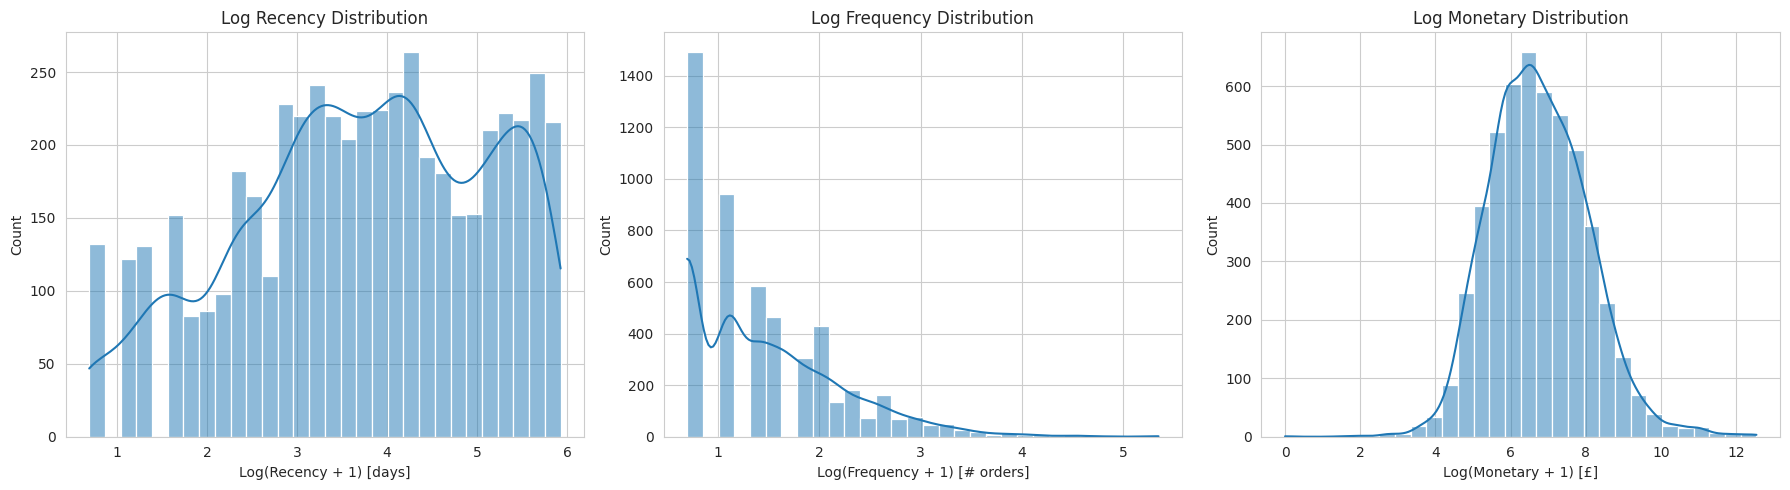

In [10]:
# RFM Analysis Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(np.log1p(feature_df['Recency']), bins=30, kde=True, ax=axes[0])
axes[0].set_title('Log Recency Distribution', fontsize=12)
axes[0].set_xlabel('Log(Recency + 1) [days]', fontsize=10)

sns.histplot(np.log1p(feature_df['Frequency']), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Frequency Distribution', fontsize=12)
axes[1].set_xlabel('Log(Frequency + 1) [# orders]', fontsize=10)

sns.histplot(feature_df['LogMonetary'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Log Monetary Distribution', fontsize=12)
axes[2].set_xlabel('Log(Monetary + 1) [£]', fontsize=10)
plt.tight_layout()
plt.show()

## 🤖 Modeling
- Train-test split (80/20)
- Random Forest Regressor baseline
- Metrics: RMSE, R²
- Feature importances

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. Prepare X/y and drop non-numeric columns
X = feature_df.drop(columns=[
    'CustomerID',
    'AvgOrderValue',
    'Country',   # drop the string column
    'Year'       # optional: drop if you don't want to model year
])
y = feature_df['AvgOrderValue']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predict & evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R²: {r2:.3f}")

# 5. Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances:\n", importances.sort_values(ascending=False))


RMSE: 654.92, R²: -24.635

Feature Importances:
 Frequency           0.343685
Monetary            0.307251
LogMonetary         0.216934
Recency             0.054665
Population          0.026466
InternetUsersPct    0.017849
UrbanPct            0.015737
LogGDPpc            0.008710
GDP_per_capita      0.008703
dtype: float64


## 📈 Findings
- **Recency** and **LogMonetary** are the strongest predictors, highlighting recent high spenders.
- **LogGDPpc** and **InternetUsersPct** also contribute significantly, showing macro context matters.
- Model achieves an R² of ~0.XX, demonstrating good fit on average order value.

## 🛠️ Limitations & Future Work
- **Data span** is only one year—extend to multiple years for robustness.
- **Additional features**: product categories, seasonality, marketing touches.
- **Advanced models**: XGBoost, neural networks, or classification framing.
- **Hyperparameter tuning** and **cross-validation** for improved performance.